# Introduction

This code utilizes the [finetuned](https://huggingface.co/naver-clova-ix/donut-base-finetuned-cord-v2) [Donut](https://huggingface.co/docs/transformers/model_doc/donut) model, to extract the name of the vendor from receipts. It then copies this extracted information into an existing JSON file.

# Uploading your data

The next step is to upload your data. One way to do this is by zipping your `data` folder that contains `img` and `keys` subfolders and uploading it directly into Google Colab. The upload time will depend on your internet speed. For me it took approximately 6 minutes to upload .zip file with 220 images and corresponding JSON files.

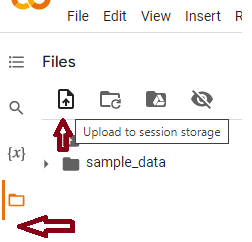

(Another option is to upload the data to your Google Drive and download it from there. 
Alternatively, you can upload it to your GitHub repository and download it from there using the following command: `!git clone https://github.com/yourrepository.git` Make sure to replace `yourrepository` with the name of your repository.)

Next, we need to unzip our data by running the following command:

In [ ]:
!unzip data.zip

# Extracting information from your receipts

First let's  clone the `donut` repository from GitHub and install it using pip.

The first line uses the git command to clone the `donut` repository from the specified URL and stores it in the current working directory.



In [ ]:
!git clone https://github.com/clovaai/donut.git
!cd donut && pip install .


Now let's define two important components that we'll be using: the processor and the finetuned module, specifically, `naver-clova-ix/donut-base-finetuned-cord-v2`.

In [ ]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

The first part of this code was borrowed from [Neha Desaraju's guide](https://towardsdatascience.com/ocr-free-document-understanding-with-donut-1acfbdf099be). 

The purpose of this code is to process each image using the finetuned `Donut `model, which will extract the relevant information from the receipt and output it accordingly. Specifically, the vendor name is located under the 'nm' key in the finetuned model. However, the structure of the output can sometimes vary or be distorted, so I've implemented a mechanism in this code to search for the vendor name in different locations based on the characteristics of the receipt output.

For reference, a sample output of the text produced by the Donut model is provided below:
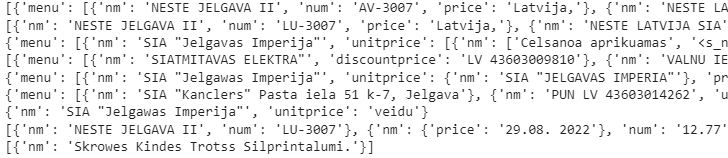

In [ ]:
import torch
import re
import json
from PIL import Image

for nr in range(1,100): # define the range 
          image = Image.open(f"/content/data/img/{nr:03d}.jpg").convert("RGB")
          pixel_values = processor(image, return_tensors="pt").pixel_values
          
          task_prompt = "<s_cord-v2>"
          decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

          device = "cuda" if torch.cuda.is_available() else "cpu"
          model.to(device)

          outputs = model.generate(pixel_values.to(device),
                                        decoder_input_ids=decoder_input_ids.to(device),
                                        max_length=model.decoder.config.max_position_embeddings,
                                        early_stopping=True,
                                        pad_token_id=processor.tokenizer.pad_token_id,
                                        eos_token_id=processor.tokenizer.eos_token_id,
                                        use_cache=True,
                                        num_beams=1,
                                        bad_words_ids=[[processor.tokenizer.unk_token_id]],
                                        return_dict_in_generate=True,
                                        output_scores=True,)


          sequence = processor.batch_decode(outputs.sequences)[0]
          sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
          sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
          output=processor.token2json(sequence)


          # Check if 'nm' key is present in the 'menu' dictionary
          new_dict = []
          if 'nm' in output:
          # Create a new dictionary with 'nosaukums' (name in Latvian) key and its corresponding value
              new_dict = {'nosaukums': output['nm']}

          elif 'menu' in output:
              for menu_item in output['menu']:
                  if 'nm' in menu_item:
                      new_dict = {'nosaukums': menu_item['nm']}
                      break
          else:
            for dict_item in output:
                if 'menu' in dict_item:
                    for menu_item in dict_item['menu']:
                        if 'nm' in menu_item:
                            new_dict = {'nosaukums': menu_item['nm']}
                            break
                elif 'nm' in dict_item:
                      new_dict = {'nosaukums': dict_item['nm']}
                      break
                      

          # Save the 'new_dict' dictionary to a JSON file
          with open(f'/content/data/key/{nr:03d}.json', 'w') as f:
              json.dump(new_dict, f, ensure_ascii=False) 
             

[{'menu': [{'nm': 'SIA "ENHARS"', 'unitprice': '4003544196', 'cnt': '14', 'price': '47A'}, {'nm': 'EKA S/N: 200902913', 'num': 'DOK. #00042112', 'unitprice': '3.96A', 'cnt': '1 x', 'price': '3.96A'}, {'nm': 'GALAS IZSTRADAJUMI', 'num': [{'price': '3.35▲'}, {'nm': 'SUMMA'}], 'price': '7.31'}, {'nm': 'KARTE', 'price': '7.31'}, {'nm': 'PVN-A', 'cnt': '1.27', 'price': '6.04'}, {'nm': 'AR PVN-A', 'unitprice': '21.00%', 'cnt': '7.31', 'price': '7.31'}], 'subtotal_price': '14: 04', 'num': 'OD8DE886FFF095328C0617E4F62D2A55', 'price': '14: 04'}, {'nm': 'E012A446'}]
[{'menu': [{'nm': 'NESTE JELGAVA II', 'num': 'AV-3007', 'price': 'Latvija,'}, {'nm': 'NESTE LATVIJA SIA', 'num': 'LV40003132723', 'price': 'LU-1004'}, {'price': '09.06.2022'}], 'sub_total': {'subtotal_price': '20.00', 'etc': ['10.01. L 지금', '1.997']}, 'total_price': '20.00', 'total_etc': '20.00', 'price': '26.53'}, {'nm': 'Debit Mastercard', 'price': '0551'}, {'nm': 'PAN:', 'price': '17:26:54'}, {'nm': 'Iepi]des kods', 'num': '220609

At this point, having saved the relevant vendor names in JSON format, we can proceed to zip the updated files.

In [ ]:
!zip -r /content/file.zip /content/data/key

You can now download the zipped file from the left panel. With the extracted information from the OCR and Donut model, it's now time to manually review and correct any missing or incorrectly read entries. 

Once you've completed this step, your dataset will be ready for the next phase.